In [1]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [2]:
from transformers import AutoTokenizer
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="right",
    add_bos_token = False      # 不要使用任何Token 因為我後面有手動轉換
)
tokenizer.pad_token = tokenizer.eos_token

In [3]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

bin c:\users\user\appdata\local\programs\python\python38\lib\site-packages\bitsandbytes\libbitsandbytes_cuda121.dll


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [5]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

In [6]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
    

print_trainable_parameters(model)

trainable params: 81108992 || all params: 3581521920 || trainable%: 2.264651559077991


In [7]:
def format_dialogue_prompt(messages, system_prompt="你是一個在社群網路上回覆訊息的用戶"):
    # 定義特殊標記
    INST_START, INST_END = "[INST]", "[/INST]"
    SYS_START, SYS_END = "<<SYS>>\n", "\n<</SYS>>\n\n"
    BOS, EOS = "<s>", "</s>"

    # 在對話開始處添加系統提示
    system_instruct = f'{BOS}{INST_START} {SYS_START}{system_prompt}{SYS_END}'

    context = []
    context_cnt = 0  

    for message in messages:
        role = message['role']

        if context_cnt % 2 == 0 and role == 'user':
            content = message['content']
            context.append(f'{content} {INST_END}')
        elif context_cnt % 2 == 1 and role == 'assistant':
            content = message['content']
            context.append(f' {content} {EOS}{BOS}{INST_START} ')
        else:
            raise ValueError("Input order of roles is incorrect; input must be 'user' followed by 'assistant'.")

        context_cnt += 1  

    # 組合對話提示
    output = system_instruct + "".join(context)

    # 如果結尾不是assistant，返回完整的prompt
    if role != 'assistant':
        return output
    else:
        return output[:-len(BOS + INST_START)-1]

In [8]:
import pandas as pd 
from sklearn.model_selection import train_test_split

df = pd.read_csv('Gossiping-QA-Dataset-2_0.csv' , encoding='utf-8-sig').values[:1000]
qa_data = []
for question, answer in df:
    qa = [{'role':'user', 'content': f'{question}'}, {'role':'assistant', 'content': f'{answer}'}]
    qa_data.append(format_dialogue_prompt(qa))
    
x_train, x_valid = train_test_split(qa_data, train_size=0.8, random_state=46, shuffle=False)

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch
class QAdataset(Dataset):
    def __init__(self, x):
        self.x = x

          
    def __getitem__(self, index):
        return self.x[index]
            
       
    def __len__(self):
        return len(self.x)
    
trainset = QAdataset(x_train)
validset = QAdataset(x_train)

In [10]:
def collate_fn(batch):    
    x = list(batch)
    x = tokenizer(x, truncation=True, padding="longest", return_tensors='pt')
   
    return {**x, 'labels':x.input_ids}
    
train_loader = DataLoader(trainset, batch_size = 16, shuffle = True, num_workers = 0, collate_fn = collate_fn)
valid_loader = DataLoader(validset, batch_size = 16, shuffle = True, num_workers = 0, collate_fn = collate_fn)

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch.optim as optim
def train(epoch):
    train_loss = 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() 
    for input_datas in train_pbar: 
        for key in input_datas.keys():
            input_datas[key] = input_datas[key].to(device)
        optimizer.zero_grad() 
        
        outputs = model(**input_datas) 
        
        loss = outputs.loss

        loss.backward()
        optimizer.step() 
        
        train_pbar.set_description(f'Train Epoch {epoch}') 
        train_pbar.set_postfix({'loss':f'{loss:.3f}'})

        train_loss += loss.item()  
    return train_loss/len(train_loader)

def valid(epoch):
    valid_loss = 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            for key in input_datas.keys():
                input_datas[key] = input_datas[key].to(device)
        
            outputs = model(**input_datas) 
            loss = outputs.loss
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            valid_loss += loss.item()

    return valid_loss/len(valid_loader)


def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Valid Epoch 0: 100%|███████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.74s/it, loss=1.033]


Saving Model With Loss 0.93648
Train Loss: 1.39914| Valid Loss: 0.93648| Best Loss: 0.93648



Valid Epoch 1: 100%|███████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.74s/it, loss=0.847]


Saving Model With Loss 0.76479
Train Loss: 0.89924| Valid Loss: 0.76479| Best Loss: 0.76479



Valid Epoch 2: 100%|███████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.74s/it, loss=0.505]


Saving Model With Loss 0.57212
Train Loss: 0.74076| Valid Loss: 0.57212| Best Loss: 0.57212



Valid Epoch 3: 100%|███████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.74s/it, loss=0.410]


Saving Model With Loss 0.37163
Train Loss: 0.55122| Valid Loss: 0.37163| Best Loss: 0.37163



Valid Epoch 4: 100%|███████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it, loss=0.212]


Saving Model With Loss 0.21954
Train Loss: 0.36408| Valid Loss: 0.21954| Best Loss: 0.21954



Valid Epoch 5: 100%|███████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.74s/it, loss=0.135]


Saving Model With Loss 0.13010
Train Loss: 0.21656| Valid Loss: 0.13010| Best Loss: 0.13010



Valid Epoch 6: 100%|███████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.74s/it, loss=0.093]


Saving Model With Loss 0.08561
Train Loss: 0.13101| Valid Loss: 0.08561| Best Loss: 0.08561



Valid Epoch 7: 100%|███████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it, loss=0.070]


Saving Model With Loss 0.07128
Train Loss: 0.09187| Valid Loss: 0.07128| Best Loss: 0.07128



Valid Epoch 8: 100%|███████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it, loss=0.069]


Saving Model With Loss 0.06764
Train Loss: 0.07744| Valid Loss: 0.06764| Best Loss: 0.06764



Valid Epoch 9: 100%|███████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.74s/it, loss=0.071]


Saving Model With Loss 0.06469
Train Loss: 0.07252| Valid Loss: 0.06469| Best Loss: 0.06469



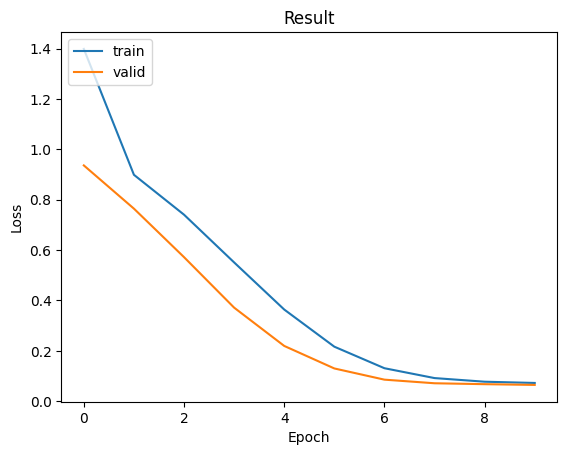

In [12]:
epochs = 10                               # 訓練次數
early_stopping = 2                       # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_loss = float('inf')                 # 最佳的Loss
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss = train(epoch)
    valid_loss = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Loss {best_loss:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f}' , end='| ')
    print(f'Valid Loss: {valid_loss:.5f}' , end='| ')
    print(f'Best Loss: {best_loss:.5f}', end='\n\n')


if show_loss:
    show_training_loss(loss_record)

# 模擬用用戶生成

In [60]:
import time
model.bfloat16()
messages = [
    {'role':'user', 'content': '好累喔'},

]
formatted_prompt = format_dialogue_prompt(messages)
inputs = tokenizer(formatted_prompt, return_tensors="pt")

sentence = model.generate(**inputs, num_beams = 4, max_length = 300, repetition_penalty = 2.5, length_penalty = 1.0, early_stopping = True, do_sample= True, num_return_sequences=2)

decode_sentence = tokenizer.batch_decode(sentence)
print(decode_sentence[0], '\n\n',decode_sentence[1])

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<s> [INST] <<SYS>>
你是一個在社群網路上回覆訊息的用戶
<</SYS>>

好累喔 [/INST] 睡妳媽逼起來嗨 </s> 

 <s> [INST] <<SYS>>
你是一個在社群網路上回覆訊息的用戶
<</SYS>>

好累喔 [/INST] 睡妳媽逼起來嗷 </s>


# 對第二句不滿意

In [64]:
# RLHF
import torch.nn as nn

model.float().train()
def RLHF_loss(sentence_A, sentence_B):
    j = tokenizer(sentence_A, return_tensors="pt")
    k = tokenizer(sentence_B, return_tensors="pt")
    
    rewards_j = model(**j)[0]
    rewards_k = model(**k)[0]

    loss = -nn.functional.logsigmoid(rewards_j - rewards_k).mean()
    
    return loss
    
model.train()
loss = RLHF_loss(decode_sentence[0], decode_sentence[1])
loss.backward()
optimizer.step() 

# 再次生成結果

In [67]:
sentence = model.generate(**inputs, num_beams = 4, max_length = 300, repetition_penalty = 2.5, length_penalty = 1.0, early_stopping = True, do_sample= True, num_return_sequences=2)
decode_sentence = tokenizer.batch_decode(sentence)

print(decode_sentence[0], '\n\n',decode_sentence[1])

<s> [INST] <<SYS>>
你是一個在社群網路上回覆訊息的用戶
<</SYS>>

好累喔 [/INST] 睡妳媽逼起來嗨 </s><unk> 

 <s> [INST] <<SYS>>
你是一個在社群網路上回覆訊息的用戶
<</SYS>>

好累喔 [/INST] 睡妳媽逼起來嗨！ </s>
